<a href="https://colab.research.google.com/github/sksoumik/machine-learning-projects/blob/master/Road_Signs_Bounding_Box_Prediction_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Statement: Predict bounding box around a Road sign in a given image and also classify the type of road sign. </br>

Dataset link: https://www.kaggle.com/andrewmvd/road-sign-detection

## download dataset from kaggle

In [1]:
from google.colab import files
files.upload() 

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle 
!kaggle datasets download -d andrewmvd/road-sign-detection

Saving kaggle.json to kaggle.json
 96% 209M/218M [00:08<00:00, 25.6MB/s]
100% 218M/218M [00:08<00:00, 26.5MB/s]


In [2]:
%%capture
!unzip road-sign-detection.zip 
!rm road-sign-detection.zip

In [3]:
# import required libraries 

import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## loading data

In [5]:
# data paths 

images_path = Path('/content/images')
anno_path = Path('/content/annotations')

In [6]:
def filelist(root, file_type):
    """Returns a list of filenames under root directory"""
    return [
        os.path.join(directory_path, f)
        for directory_path, directory_name, files in os.walk(root)
        for f in files if f.endswith(file_type)
    ]


def generate_train_df(anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(
            str(images_path) + '/' + root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [7]:
# create the train datapath 

df_train = generate_train_df(anno_path)

In [8]:
# encode target labels 

class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x: class_dict[x])

In [9]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/images/road175.png,300,400,0,172,180,225,237
1,/content/images/road629.png,300,400,0,146,96,250,203
2,/content/images/road133.png,400,235,2,103,51,220,168
3,/content/images/road78.png,400,267,1,72,38,153,112
4,/content/images/road584.png,300,400,0,145,161,175,190


In [10]:
df_train['class'].value_counts()

0    652
2     88
1     76
3     61
Name: class, dtype: int64

## resizing image and bounding boxes

In [11]:
#Reading an image

def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [12]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows, cols, *_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols) == 0:
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row],
                    dtype=np.float32)


def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5], x[4], x[7], x[6]])

In [13]:
def resize_image_bb(read_path, write_path, bb, sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49 * sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49 * sz), sz))
    new_path = str(write_path / read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [14]:
Path('/content/images_resized').mkdir(parents=True, exist_ok=True)

In [15]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('/content/images_resized')
for index, row in df_train.iterrows():
    new_path, new_bb = resize_image_bb(row['filename'], train_path_resized,
                                       create_bb_array(row.values), 300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

In [16]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(400, 300, 3)


In [17]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([100.,  93., 199., 160.], dtype=float32)

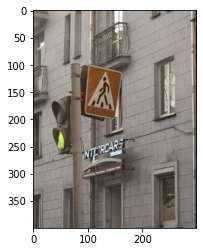

In [18]:
plt.imshow(im)

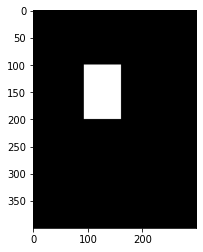

In [19]:
plt.imshow(Y, cmap='gray')

## data augmentation

In [20]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c):
    return im[r:r + target_r, c:c + target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c, *_ = x.shape
    c_pix = round(r_pix * c / r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    return crop(x, start_r, start_c, r - 2 * r_pix, c - 2 * c_pix)


def center_crop(x, r_pix=8):
    r, c, *_ = x.shape
    c_pix = round(r_pix * c / r)
    return crop(x, r_pix, c_pix, r - 2 * r_pix, c - 2 * c_pix)

In [21]:
def rotate_cv(im,
              deg,
              y=False,
              mode=cv2.BORDER_REFLECT,
              interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r, c, *_ = im.shape
    M = cv2.getRotationMatrix2D((c / 2, r / 2), deg, 1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,
                          M, (c, r),
                          borderMode=mode,
                          flags=cv2.WARP_FILL_OUTLIERS + interpolation)


def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c, *_ = x.shape
    c_pix = round(r_pix * c / r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2 * r_pix, c - 2 * c_pix)
    YY = crop(Y, start_r, start_c, r - 2 * r_pix, c - 2 * c_pix)
    return xx, YY


def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random() - .50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5:
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [22]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

## sample image

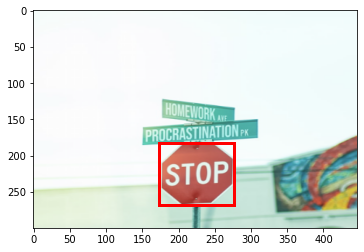

In [23]:
#original
im = cv2.imread(str(df_train.values[68][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[68][9])

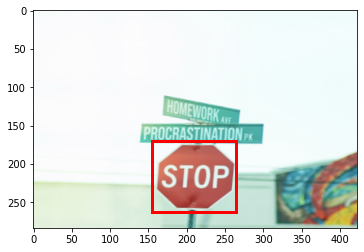

In [24]:
# after transformation
im, bb = transformsXY(str(df_train.values[68][8]), df_train.values[68][9],
                      True)
show_corner_bb(im, bb)

## train valid split

In [25]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

## dataset

In [26]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]

In [27]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [28]:
train_ds = RoadDataset(X_train['new_path'],
                       X_train['new_bb'],
                       y_train,
                       transforms=True)
valid_ds = RoadDataset(X_val['new_path'], X_val['new_bb'], y_val)

In [29]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

## Model

In [30]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

## Training

In [31]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [32]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10, C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb / C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss / total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" %
              (train_loss, val_loss, val_acc))
    return sum_loss / total

In [33]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb / C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss / total, correct / total

In [34]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [35]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

train_loss 2.304 val_loss 6514947.818 val_acc 0.091
train_loss 1.530 val_loss 2614.807 val_acc 0.131
train_loss 1.517 val_loss 20.419 val_acc 0.511
train_loss 1.316 val_loss 2.070 val_acc 0.739
train_loss 1.169 val_loss 1.357 val_acc 0.739
train_loss 1.039 val_loss 1.080 val_acc 0.756
train_loss 0.907 val_loss 0.873 val_acc 0.727
train_loss 0.861 val_loss 0.943 val_acc 0.744
train_loss 0.886 val_loss 0.960 val_acc 0.710
train_loss 0.855 val_loss 0.962 val_acc 0.733
train_loss 0.916 val_loss 0.889 val_acc 0.733
train_loss 0.929 val_loss 0.835 val_acc 0.767
train_loss 0.857 val_loss 1.048 val_acc 0.688
train_loss 0.901 val_loss 0.973 val_acc 0.699
train_loss 0.890 val_loss 16.346 val_acc 0.722


0.890091796744397

In [36]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

train_loss 0.876 val_loss 0.790 val_acc 0.784
train_loss 0.824 val_loss 0.778 val_acc 0.784
train_loss 0.813 val_loss 0.823 val_acc 0.773
train_loss 0.748 val_loss 0.754 val_acc 0.795
train_loss 0.737 val_loss 0.726 val_acc 0.807
train_loss 0.752 val_loss 0.748 val_acc 0.812
train_loss 0.740 val_loss 0.743 val_acc 0.807
train_loss 0.713 val_loss 0.705 val_acc 0.818
train_loss 0.713 val_loss 0.704 val_acc 0.818
train_loss 0.704 val_loss 0.749 val_acc 0.795


0.7036793718324408

In [37]:
# choose random image from validation set
X_val

,new_path,new_bb
710,/content/images_resized/road451.png,"[111.0, 144.0, 152.0, 229.0]"
734,/content/images_resized/road3.png,"[134.0, 198.0, 260.0, 263.0]"
244,/content/images_resized/road57.png,"[26.0, 35.0, 205.0, 423.0]"
231,/content/images_resized/road334.png,"[126.0, 163.0, 151.0, 211.0]"
291,/content/images_resized/road770.png,"[123.0, 205.0, 145.0, 255.0]"
...,...,...
500,/content/images_resized/road602.png,"[146.0, 130.0, 168.0, 176.0]"
215,/content/images_resized/road138.png,"[68.0, 189.0, 124.0, 253.0]"
350,/content/images_resized/road22.png,"[32.0, 150.0, 136.0, 209.0]"
81,/content/images_resized/road834.png,"[108.0, 180.0, 134.0, 232.0]"


In [38]:
# resizing test image
im = read_image('/content/images_resized/road138.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('/content/road789.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [39]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'/content/road789.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [40]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [41]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 0.9940, -2.1558,  3.7398, -0.8046]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[106.0494, 172.5547, 163.6482, 259.7335]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [42]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(values=tensor([3.7398], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([2], device='cuda:0'))

tensor([2], means crosswalk

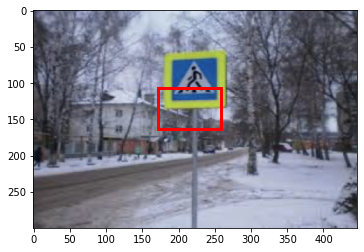

In [43]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])